In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

C:\Users\jweidner\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = sm.datasets.co2.load_pandas()
y=data.data

In [3]:
# 'MS' parameter groups the data in buckets by month
y=y['co2'].resample('MS').mean()

In [4]:
# bfill() uses value before when filling in na values
y=y.fillna(y.bfill())

#### Here are the observed levels of CO2 in the dataset

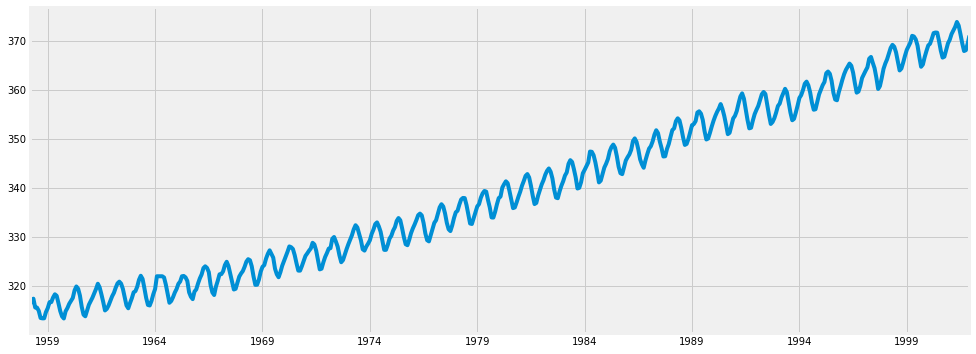

In [5]:
y.plot(figsize=(15,6))

### Begin Building ARIMA Model for forecasting

In [6]:
# establish p, d, q to take any value between 0 and 2 to test model parameters by iteration
p = d = q = range(0,2)

pdq=list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [7]:
# now have iterable list of parameters to feed to model
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [8]:
warnings.filterwarnings('ignore') #specifies to ignore warnings
AICmin = 1000000000
opt_params = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                           order = param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertability=False)
            results = mod.fit()
            if results.aic < AICmin:
                AICmin = results.aic
                opt_params= [AICmin, param, param_seasonal]
            
            print('Arima{}x{}12 - AIC: {}'.format(param, param_seasonal, results.aic))
        except:
            continue
print('AIC & Optimal Parameters:{}'.format(opt_params))

Arima(0, 0, 0)x(0, 1, 1, 12)12 - AIC: 1596.71117274
Arima(0, 0, 0)x(1, 0, 0, 12)12 - AIC: 1058.93889213
Arima(0, 0, 0)x(1, 0, 1, 12)12 - AIC: 1056.28803621
Arima(0, 0, 0)x(1, 1, 0, 12)12 - AIC: 1361.65789781
Arima(0, 0, 0)x(1, 1, 1, 12)12 - AIC: 1044.76482286
Arima(0, 0, 1)x(0, 1, 0, 12)12 - AIC: 1379.19410672
Arima(0, 0, 1)x(0, 1, 1, 12)12 - AIC: 1241.41747165
Arima(0, 0, 1)x(1, 1, 0, 12)12 - AIC: 1119.59578938
Arima(0, 0, 1)x(1, 1, 1, 12)12 - AIC: 807.093664613
Arima(0, 1, 0)x(0, 0, 1, 12)12 - AIC: 1240.22111992
Arima(0, 1, 0)x(0, 1, 1, 12)12 - AIC: 337.79385431
Arima(0, 1, 0)x(1, 0, 0, 12)12 - AIC: 619.950175906
Arima(0, 1, 0)x(1, 0, 1, 12)12 - AIC: 376.928376654
Arima(0, 1, 0)x(1, 1, 0, 12)12 - AIC: 478.329690667
Arima(0, 1, 0)x(1, 1, 1, 12)12 - AIC: 323.324608699
Arima(0, 1, 1)x(0, 0, 0, 12)12 - AIC: 1371.18726023
Arima(0, 1, 1)x(0, 0, 1, 12)12 - AIC: 1101.84107345
Arima(0, 1, 1)x(0, 1, 0, 12)12 - AIC: 587.947970969
Arima(0, 1, 1)x(0, 1, 1, 12)12 - AIC: 302.494900363
Arima(0, 1, 1

In [9]:
mod = sm.tsa.statespace.SARIMAX(y,
                               order=opt_params[1],
                               seasonal_order=opt_params[2],
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.162      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.810      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


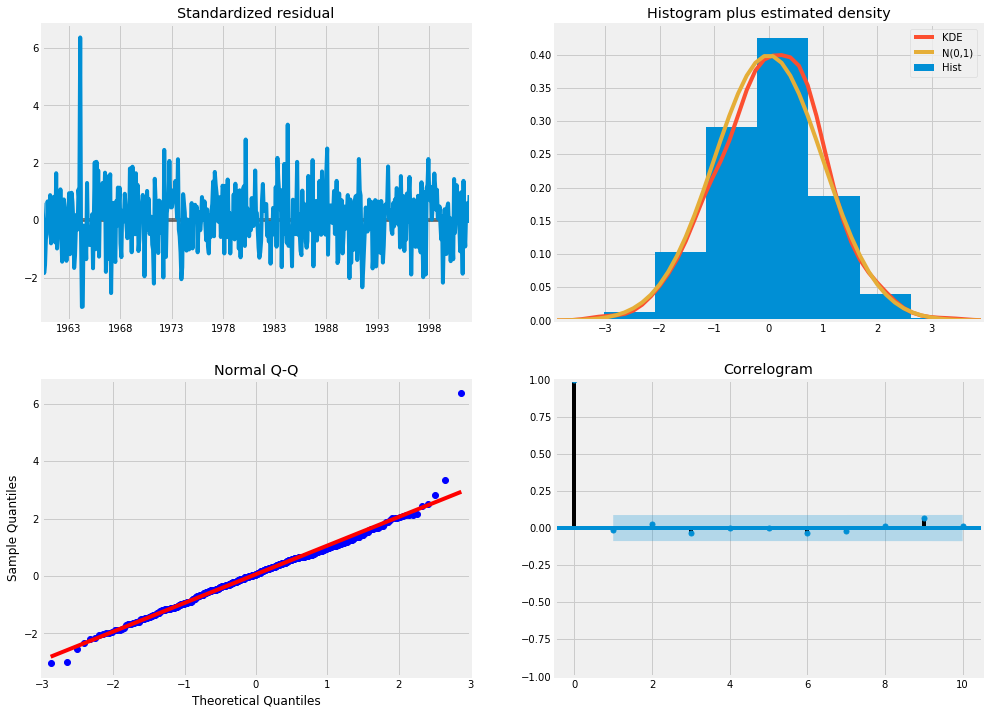

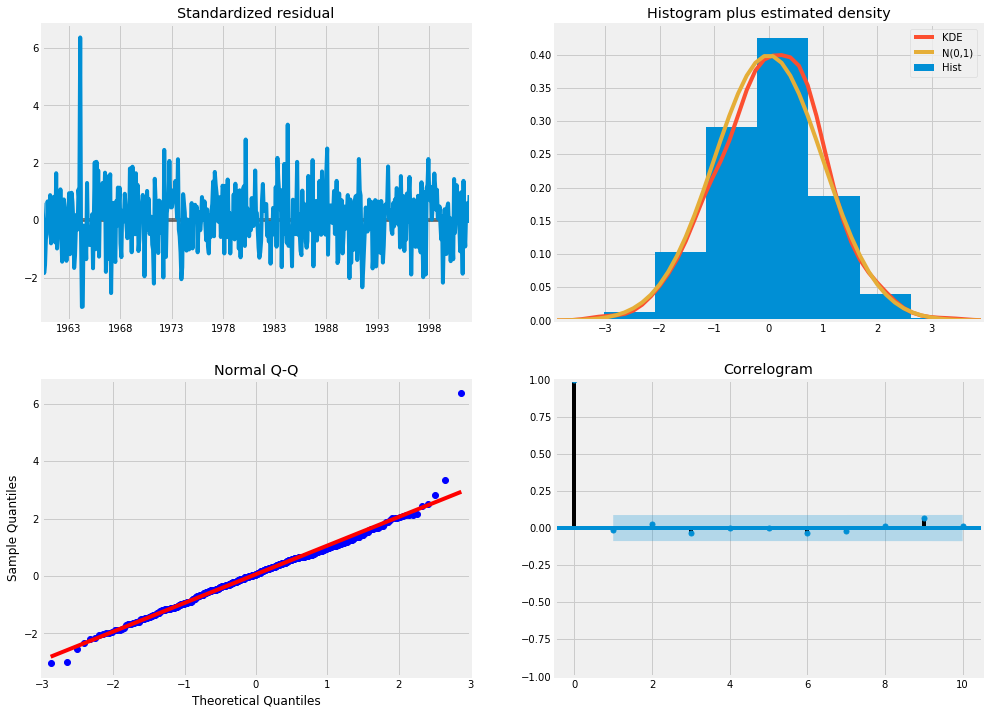

In [10]:
results.plot_diagnostics(figsize=(15,12))

#### Without dynamic forecasting, using entirety of available historical data

In [11]:
# compare prediction to actual values of the time series
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False) #dynamic parameter ensures we use all data up to current point for every forecast
pred_ci = pred.conf_int()

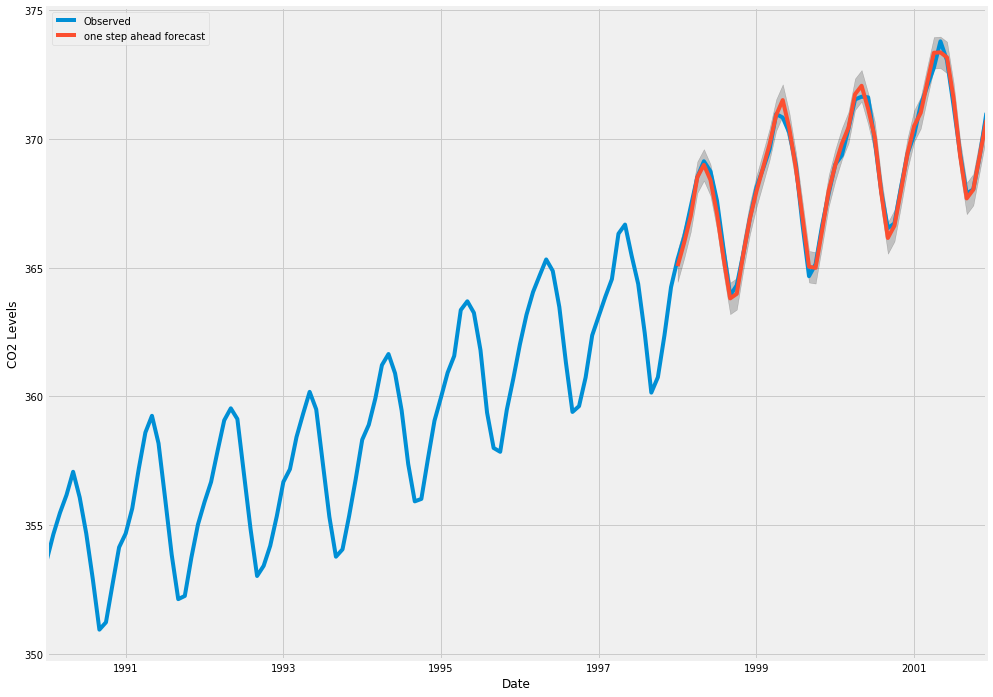

In [12]:
ax = y['1990':].plot(label='Observed', figsize=(15,12))
pred.predicted_mean.plot(ax=ax, label='one step ahead forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color='k', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

Calculate MSE, 0 is perfect model.

In [13]:
y_hat = pred.predicted_mean
y_true = y['1998-01-01':]

mse = ((y_hat-y_true)**2).mean()
print('MSE: {0:.2f}'.format(mse))

MSE: 0.07


#### With dynamic forecasting, so using only a certain amount of prior data

In [14]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

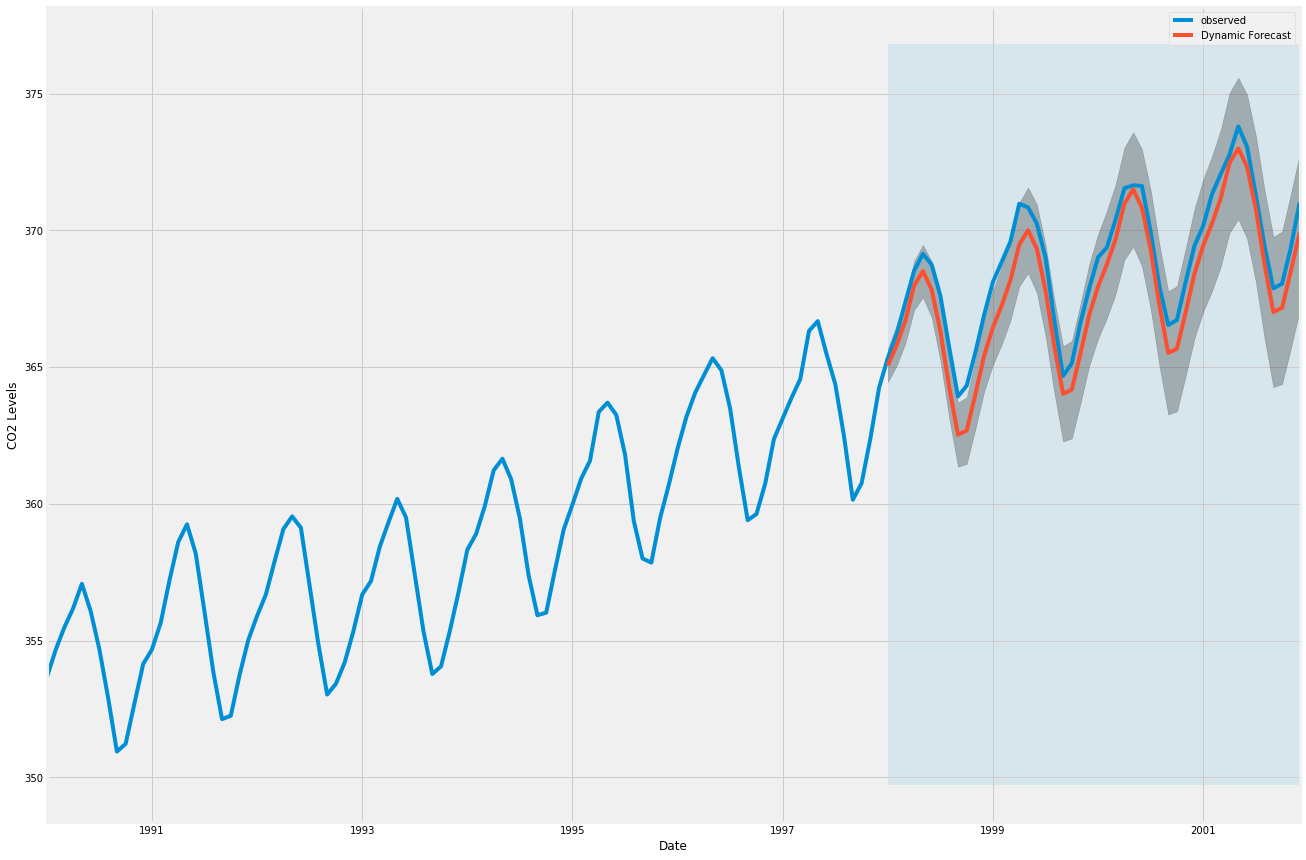

In [15]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1) # shade the section we're validating our prediction on

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()

Now calculate MSE, a 0 would be a perfect model.

In [16]:
# Extract the predicted and true values of our time series
y_hat = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_hat - y_truth) ** 2).mean()
print('MSE: {0:.2f}'.format(mse))

MSE: 1.01


#### Forecasting far into the future, now that we have established we have a good working model.

In [17]:
pred_far = results.get_forecast(steps=500)
ci_far = pred_far.conf_int()

In [18]:
pred_far.predicted_mean.index[-1]

Timestamp('2043-08-01 00:00:00', freq='MS')

In [19]:
df = pd.DataFrame(pred_far.predicted_mean)
df['y_fiction'] = [x*0.975 for x in df[0]]

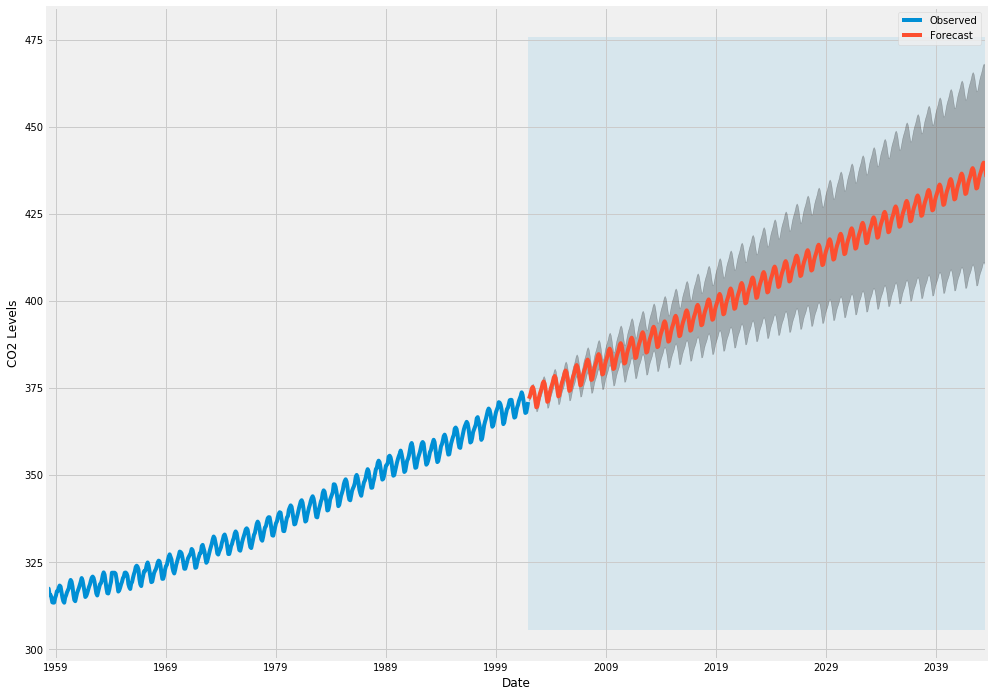

In [20]:
_ = y.plot(label = 'Observed', figsize = (15,12))
pred_far.predicted_mean.plot(ax=_, label='Forecast')

#testing implementations of hypothetical future trend
#df['y_fiction'].plot(ax=_, label='fiction')

_.fill_between(ci_far.index,
              ci_far.iloc[:, 0],
              ci_far.iloc[:,1], color='k', alpha=0.25)

#fill area to indicate future
_.fill_betweenx(_.get_ylim(), y.index[-1], pred_far.predicted_mean.index[-1],
                 alpha=0.1, zorder=-1) 

_.set_xlabel('Date')
_.set_ylabel('CO2 Levels')

plt.legend()